# Melakukan Prediksi dengan menggunakan model LSTM

Model LSTM (Long Short Term Memory) merupakan Deep Neural Network yang mampu melakukan prediksi pergerakan saham ataupun jenis prediksi lainnya. Untuk menggunakan model ini, ada beberapa hal yang harus diperlukan, yaitu :
1. Membuat data generator <br/>Sebelum membuat data generator, data harus dibersihkan dan dilakukan Pre-processing
2. Menentukan hyperparameter yang tepat untuk meminimalisir nilai Error <br/>Untuk menentukan nilai hyperparameter yang tepat, dapat dilihat di <a href="s.id/hyper_lstm_saham"> **sini**</a>
3. Melakukan visualisasi dan evaluasi
4. Menganalisa secara teknikal yang bisa dilihat di <a href="s.id/teknikal_lstm_saham"> **sini**</a>

# Membersihkan Data dan melakukan Pre-Processing

## Library yang digunakan <br/>
Tahap awal adalah menentukan dan mendownload library yang akan digunakan. Di bawah ini adalah library - library yang akan digunakan dalam penelitian ini

In [1]:
pip install tqdm --upgrade

     |████████████████████████████████| 61kB 5.1MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [2]:
# Numpy untuk formatting number atau array
import numpy as np

# Pandas untuk membuat DataFrame dan membaca dokumen csv
import pandas as pd 

# Tensorflow dan Keras sebagai Framework dan Backend
import keras
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers

# Sklearn sebagai komponen machine learning, untuk normalisasi, membagi dataset dan menghitung nilai error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Logging untuk mencatat tiap aktivitas yang dilakukan sistem
import logging

# Pickle untuk mengambil model jika sudah dibuat sebelumnya
import pickle

# OS untuk operation system, sys untuk system, time untuk waktu, tqdm notebook untuk notebook jika dibuat selain google colab
import os
import sys
import time
from tqdm._tqdm_notebook import tqdm_notebook

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


## Mengatur zona waktu dan logging
Zona waktu digunakan untuk mengetahui seberapa lama sistem akan melatih data, dan logging digunakan untuk mencatat segala aktivitas yang dilakukan

In [0]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Kolkata'  
time.tzset()

In [4]:
print("Penelitian ini menggunakan Framework Keras versi " + keras.__version__ + " dan Backend Tensorflow versi " + tf.__version__)

Penelitian ini menggunakan Framework Keras versi 2.2.5 dan Backend Tensorflow versi 1.15.0


## Membaca dataset dan membagi dataset
Dataset yang digunakan berupa Historical Data Price PT Adaro Energy Tbk sejak 2008 sampai 3 januari 2020

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
params = {
    "batch_size": 20, 
    "epochs": 200,
    "lr": 0.0001,
    "time_steps": 50
}
iter_changes = "dropout_layers_0.4_0.4"

In [0]:
INPUT_PATH = "/content/drive/My Drive/TA_LSTM"+"/inputs"
OUTPUT_PATH = "/content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/"+"iter_changes"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [8]:
if not os.path.exists(OUTPUT_PATH):
  os.makedirs(OUTPUT_PATH)
  print("Direktori output dibuat di ", OUTPUT_PATH)
else:
  print("Direktori sudah dibuat sebelumnya")

Direktori sudah dibuat sebelumnya


In [9]:
stime = time.time()
print(os.listdir(INPUT_PATH))

# Membaca Dataset
df = pd.read_csv(os.path.join(INPUT_PATH, "ADRO.JK(max).csv"), engine='python')
df = df.dropna()
df = df.reset_index(drop=True)
print(df.shape)
print(df.columns)
display(df.head(5))

# Menampilkan Feature dan Tipe Data yang digunakan
print("\n Tipe data pada Fitur yang digunakan :")
print(df.dtypes)

# Mendefinisikan variable baru untuk menampung Feature
train_cols = ["Open","High","Low","Close","Volume"]

# Membagi dataset menjadi 80% untuk Data Latih dan 20% untuk Data Uji
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("\nBanyaknya Data Latih : ", len(df_train))
print("Banyaknya Data Uji : ", len(df_test))

['ADRO.JK(3m).csv', 'ADRO.JK(5y).csv', 'ADRO.JK(1y).csv', 'ADRO.JK(6m).csv', 'ADRO.JK(max).csv']
(2828, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-07-16,1500.0,1760.0,1500.0,1730.0,1136.119507,789786000.0
1,2008-07-17,1700.0,1760.0,1700.0,1700.0,1116.418213,383602500.0
2,2008-07-18,1640.0,1700.0,1640.0,1640.0,1077.014893,95396000.0
3,2008-07-21,1680.0,1690.0,1640.0,1680.0,1103.283691,49749000.0
4,2008-07-22,1670.0,1690.0,1660.0,1670.0,1096.716309,29585500.0



 Tipe data pada Fitur yang digunakan :
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

Banyaknya Data Latih :  2262
Banyaknya Data Uji :  566


In [10]:
# Split skip 2 hari untuk prediksi tanggal 4, dimulai dari tanggal 2 januari, 27 desember dll
df2 = df.iloc[::2]
df2_train, df2_test = train_test_split(df2, train_size=0.8, test_size=0.2, shuffle=False)
print("\nBanyaknya Data Latih : ", len(df2_train))
print("Banyaknya Data Uji : ", len(df2_test))
df2.tail()


Banyaknya Data Latih :  1131
Banyaknya Data Uji :  283


,Date,Open,High,Low,Close,Adj Close,Volume
2818,2019-12-17,1660.0,1665.0,1525.0,1655.0,1582.512085,152206000.0
2820,2019-12-19,1610.0,1625.0,1545.0,1595.0,1525.140015,75920100.0
2822,2019-12-23,1540.0,1590.0,1540.0,1580.0,1510.796997,51031300.0
2824,2019-12-27,1590.0,1610.0,1575.0,1580.0,1510.796997,31331800.0
2826,2020-01-02,1555.0,1555.0,1490.0,1495.0,1429.520020,76612000.0


In [11]:
# Split skip 2 hari untuk prediksi tanggal 5, dimulai dari tanggal 3 januari, 30 desember dll
df3 = df.iloc[1::2]
df3_train, df3_test = train_test_split(df3, train_size=0.8, test_size=0.2, shuffle=False)
print("\nBanyaknya Data Latih : ", len(df3_train))
print("Banyaknya Data Uji : ", len(df3_test))
df3.tail()


Banyaknya Data Latih :  1131
Banyaknya Data Uji :  283


,Date,Open,High,Low,Close,Adj Close,Volume
2819,2019-12-18,1655.0,1655.0,1595.0,1610.0,1539.483032,68583400.0
2821,2019-12-20,1605.0,1605.0,1505.0,1540.0,1472.549072,88766700.0
2823,2019-12-26,1590.0,1620.0,1570.0,1585.0,1515.578003,41404600.0
2825,2019-12-30,1565.0,1590.0,1555.0,1555.0,1486.891968,49275500.0
2827,2020-01-03,1460.0,1470.0,1425.0,1465.0,1465.000000,117795600.0


## Visualisasi terhadap dataset
Visualisasi ini bertujuan untuk mengetahui OHLC (Open, High, Low, Close) dengan menampilkan nya berbentuk grafik candle stick

In [12]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.show()

## Melakukan Normalisasi data
Normalisasi data dilakukan untuk memudahkan melakukan prediksi. Normalisasi yang digunakan berupa MinMaxScaller.

In [0]:
# Melakukan Normalisasi untuk Data Latih dan Data Uji
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [0]:
# Melakukan Normalisasi untuk Data Latih dan Data Uji
x2 = df2_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x2_train = min_max_scaler.fit_transform(x2)
x2_test = min_max_scaler.transform(df2_test.loc[:,train_cols])

In [0]:
# Melakukan Normalisasi untuk Data Latih dan Data Uji
x3 = df3_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x3_train = min_max_scaler.fit_transform(x3)
x3_test = min_max_scaler.transform(df3_test.loc[:,train_cols])

## Menghapus data yang tidak diperlukan


In [16]:
print("Menghapus dataframe yang tidak terpakai . . .")
apus  = (sys.getsizeof(df)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024
print ("Dataframe terhapus sebesar ", apus ," KB")
del df_test
del df_train
del x
print ("Proses penghapusan selesai")

Menghapus dataframe yang tidak terpakai . . .
Dataframe terhapus sebesar  657  KB
Proses penghapusan selesai


In [17]:
print("Menghapus dataframe yang tidak terpakai . . .")
apus  = (sys.getsizeof(df2)+sys.getsizeof(df2_train)+sys.getsizeof(df2_test))//1024
print ("Dataframe terhapus sebesar ", apus ," KB")
del df2_test
del df2_train
del x2
print ("Proses penghapusan selesai")

Menghapus dataframe yang tidak terpakai . . .
Dataframe terhapus sebesar  328  KB
Proses penghapusan selesai


In [18]:
print("Menghapus dataframe yang tidak terpakai . . .")
apus  = (sys.getsizeof(df3)+sys.getsizeof(df3_train)+sys.getsizeof(df3_test))//1024
print ("Dataframe terhapus sebesar ", apus ," KB")
del df3_test
del df3_train
del x3
print ("Proses penghapusan selesai")

Menghapus dataframe yang tidak terpakai . . .
Dataframe terhapus sebesar  328  KB
Proses penghapusan selesai


# Proses Data Generator untuk Model LSTM
Proses ini terdiri dari beberapa step, yaitu :
1. Memangkas dataset
2. Membuat time series


## Memangkas Dataset
Pemangkasan ini bertujuan untuk membuang data yang tidak diperlukan

In [0]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"menit : ",np.round(seconds%60),"detik")

In [0]:
def trim_dataset(mat,batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

## Membuat Time Series
Hal ini dilakukan untuk mengubah dimensi dari dataset, yang semula 2 dimensi, menjadi 3 dimensi. Dimensi tersebut adalah input data, jumlah data yang akan dijadikan ukuran untuk back-forward dan feature yang digunakan

In [0]:
def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("Ukuran time-series untuk Input dan Output : ",x.shape,y.shape)
    return x, y

In [22]:
# Pengecekan data yang masih null
print("Apa masih ada data yang berisikan null?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Data yang sudah dipangkas menjadi : ",x_t.shape, y_t.shape)

Apa masih ada data yang berisikan null? False False
dim_0 2212



Ukuran time-series untuk Input dan Output :  (2212, 50, 5) (2212,)
Data yang sudah dipangkas menjadi :  (2200, 50, 5) (2200,)


In [23]:
# Pengecekan data yang masih null
print("Apa masih ada data yang berisikan null?",np.isnan(x2_train).any(), np.isnan(x2_train).any())
x2_t, y2_t = build_timeseries(x2_train, 3)
x2_t = trim_dataset(x2_t, BATCH_SIZE)
y2_t = trim_dataset(y2_t, BATCH_SIZE)
print("Data yang sudah dipangkas menjadi : ",x2_t.shape, y2_t.shape)

Apa masih ada data yang berisikan null? False False
dim_0 1081



Ukuran time-series untuk Input dan Output :  (1081, 50, 5) (1081,)
Data yang sudah dipangkas menjadi :  (1080, 50, 5) (1080,)


In [24]:
# Pengecekan data yang masih null
print("Apa masih ada data yang berisikan null?",np.isnan(x3_train).any(), np.isnan(x3_train).any())
x3_t, y3_t = build_timeseries(x3_train, 3)
x3_t = trim_dataset(x3_t, BATCH_SIZE)
y3_t = trim_dataset(y3_t, BATCH_SIZE)
print("Data yang sudah dipangkas menjadi : ",x3_t.shape, y3_t.shape)

Apa masih ada data yang berisikan null? False False
dim_0 1081



Ukuran time-series untuk Input dan Output :  (1081, 50, 5) (1081,)
Data yang sudah dipangkas menjadi :  (1080, 50, 5) (1080,)


In [25]:
# Membuat Time-Series dari data uji
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

dim_0 516



Ukuran time-series untuk Input dan Output :  (516, 50, 5) (516,)


In [26]:
# Membuat Time-Series dari data uji
x2_temp, y2_temp = build_timeseries(x2_test, 3)
x2_val, x2_test_t = np.split(trim_dataset(x2_temp, BATCH_SIZE),2)
y2_val, y2_test_t = np.split(trim_dataset(y2_temp, BATCH_SIZE),2)

dim_0 233



Ukuran time-series untuk Input dan Output :  (233, 50, 5) (233,)


In [27]:
# Membuat Time-Series dari data uji
x3_temp, y3_temp = build_timeseries(x3_test, 3)
x3_val, x3_test_t = np.split(trim_dataset(x3_temp, BATCH_SIZE),2)
y3_val, y3_test_t = np.split(trim_dataset(y3_temp, BATCH_SIZE),2)

dim_0 233



Ukuran time-series untuk Input dan Output :  (233, 50, 5) (233,)


In [28]:
print("Banyaknya ukuran data validasi :", x_val.shape, y_val.shape)

Banyaknya ukuran data validasi : (250, 50, 5) (250,)


In [29]:
print("Banyaknya ukuran data validasi :", x2_val.shape, y2_val.shape)

Banyaknya ukuran data validasi : (110, 50, 5) (110,)


In [30]:
print("Banyaknya ukuran data validasi :", x3_val.shape, y3_val.shape)

Banyaknya ukuran data validasi : (110, 50, 5) (110,)


# Membuat model LSTM
Pembuatan model ini tidak terlepas dari hyperparameter yang digunakan, banyanya sel LSTM yang dibuat dan banyaknya hidden layer yang dibuat

In [0]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(256, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(256, dropout=0.4))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(128,activation='tanh'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    #optimizer = optimizers.RMSprop(lr=params["lr"])
    optimizer = optimizers.Adam(lr=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False, epsilon=None) # ini yg paling optimal
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    return lstm_model

In [32]:
model = None
try:
    #model = pickle.load(open("/content/drive/My Drive/TA_LSTM/outputs/lstm_model", 'rb'))
    model = pickle.load(open("lstm_model", 'rb'))
    print("Model ditemukan. Menggunakan model yang sudah ada . . .")
except FileNotFoundError:
    print("Model tidak ditemukan")

Model tidak ditemukan


In [33]:
'''
if(not os.path.exists('/content/drive/My Drive/TA_LSTM/outputs/best_model.h5')):
  print("Model belum dibuat sebelumnya")
else:
  print("Model sudah dibuat sebelumnya. Model akan dimuat sesaat lagi . . .")
  model = load_model('/content/drive/My Drive/TA_LSTM/outputs/best_model.h5')
  print("Model dimuat")
'''

'\nif(not os.path.exists(\'/content/drive/My Drive/TA_LSTM/outputs/best_model.h5\')):\n  print("Model belum dibuat sebelumnya")\nelse:\n  print("Model sudah dibuat sebelumnya. Model akan dimuat sesaat lagi . . .")\n  model = load_model(\'/content/drive/My Drive/TA_LSTM/outputs/best_model.h5\')\n  print("Model dimuat")\n'

# Melakukan iterasi untuk melatih data dalam beberapa Epoch

In [34]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Membuat Model ...")
    print("Mengecek ketersediaan GPU ...", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("Menyimpan model . . .")
    pickle.dump(model, open("lstm_model", "wb"))
    model.save("best_model.h5")

Membuat Model ...
Mengecek ketersediaan GPU ... ['/job:localhost/replica:0/task:0/device:GPU:0']
Train on 2200 samples, validate on 240 samples
Epoch 1/200
 - 22s - loss: 0.0646 - acc: 4.5455e-04 - val_loss: 0.0444 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.04442, saving model to /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes/best_model.h5
Epoch 2/200
 - 13s - loss: 0.0490 - acc: 9.0909e-04 - val_loss: 0.0348 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.04442 to 0.03484, saving model to /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes/best_model.h5
Epoch 3/200
 - 13s - loss: 0.0248 - acc: 9.0909e-04 - val_loss: 0.0168 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.03484 to 0.01683, saving model to /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes/best_model.h5
Epoch 4/200
 - 13s - loss: 0.0114 - acc: 9.0909e-04 - val_loss: 0.0090 - val_acc: 0.0000e+00

E

# Melakukan Prediksi
Setelah data berhasil dilatih dengan model yang sudah dibuat, maka selanjutnya adalah proses prediksi

## Prediksi dengan data yang masih Normal

In [35]:
# Melakukan Prediksi dengan model yang sudah dibuat
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)

# Menampilkan nilai Error menggunakan MSE
print("Besarnya nilai Error : ", error, y_pred.shape, y_test_t.shape)

Besarnya nilai Error :  0.00027997401430813264 (240,) (240,)


## Proses Denormalisasi data hasil prediksi

In [0]:
# Melakukan De-normalisasi data output untuk data uji dan data validasi
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

# Visualisasi data output

## Visualisasi nilai Loss yang dihasilkan

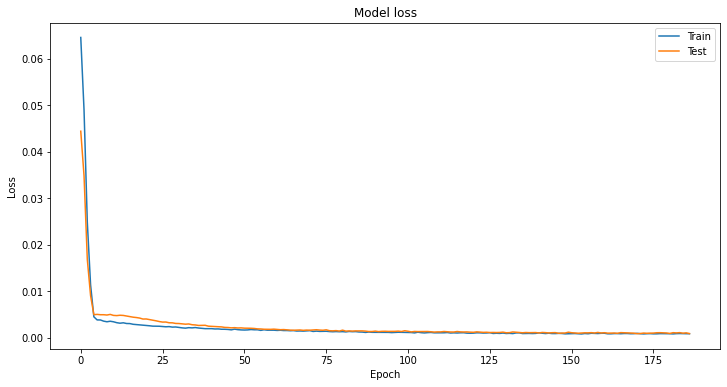

In [37]:
# Visualisasi model Loss dari data uji dan data validasi
from matplotlib import pyplot as plt
plt.figure(figsize=[12,6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

In [38]:
# Menyimpan model
#saved_model = load_model(os.path.join(OUTPUT_PATH, '/content/drive/My Drive/TA_LSTM/outputs/best_model.h5')) 
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) 
print(saved_model)

In [39]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Nilai Error dari MSE sebesar ", error, y_pred.shape, y_test_t.shape)
print("Harga prediksi esok hari sebelum denormalisasi :",y_pred[0])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] 
print("Harga prediksi esok hari sesudah denormalisasi :",y_pred_org[0])

Nilai Error dari MSE sebesar  0.000295357664705621 (240,) (240,)
Harga prediksi esok hari sebelum denormalisasi : 0.33788604
Harga prediksi esok hari sesudah denormalisasi : 1268.7115


## Visualisasi hasil prediksi

In [0]:
kurang = y_pred_org - y_test_t_org
kurang_table = pd.DataFrame(kurang, columns=['hasil pengurangan uji dgn validasi'])
kurang_table.to_csv (r'/content/drive/My Drive/TA_LSTM/outputs/Hasil pengurangan ep200 8020.csv', index = None, header=True) 

Program selesai pada  39.0 menit :  43.0 detik


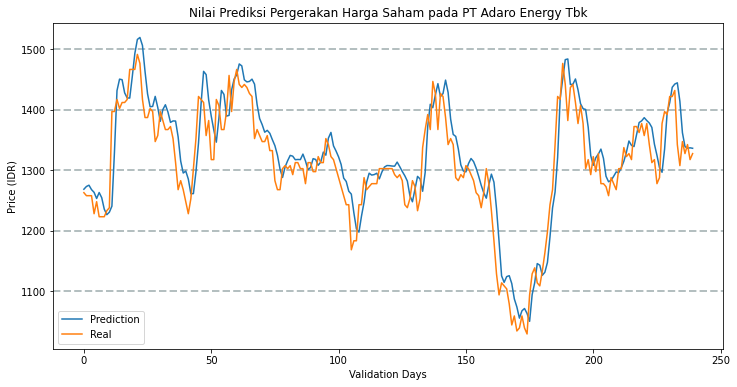

In [41]:
# Visualisasi hasil prediksi dengan model yang sudah dibuat
from matplotlib import pyplot as plt
plt.figure(figsize=[12,6])
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Nilai Prediksi Pergerakan Harga Saham pada PT Adaro Energy Tbk')
plt.ylabel('Price (IDR)')
plt.xlabel('Validation Days')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.legend(['Prediction', 'Real'], loc='lower left')
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("Program selesai pada ", stime)

# Evaluasi Model yang sudah dibuat

In [42]:
# Evaluasi model
score = model.evaluate(x_t, y_t, batch_size=BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2200/2200 [==============================] - 6s 3ms/step
Test loss: 0.0005083735387663844
Test accuracy: 0.0009090909226374192



















# Menyimpan hasil prediksi ke dalam csv

In [43]:
# Menyimpan hasil data prediksi ke dalam bentuk Dataframe
pred_table = pd.DataFrame(y_pred_org, columns=['Close'])

# Melakukan Ekspor data menjadi bentuk CSV
export_csv = pred_table.to_csv (r'/content/drive/My Drive/TA_LSTM/outputs/Prediksi Close Price.csv', index = None, header=True) 
print ("Dokumen CSV sudah tersimpan di direktori", OUTPUT_PATH)

Dokumen CSV sudah tersimpan di direktori /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes


In [44]:
# Menggabungkan dataset dengan data lama
df_close = df.drop(columns=['Date','Open', 'High', 'Low', 'Adj Close', 'Volume'])
df_new = pd.concat([df_close, pred_table], ignore_index=True, sort=True)

# Menyimpan dataset baru
export_csv = df_new.to_csv(r'/content/drive/My Drive/TA_LSTM/outputs/Dataset baru.csv', index = None, header=True) 
print ("Dokumen CSV sudah tersimpan di direktori", OUTPUT_PATH)

Dokumen CSV sudah tersimpan di direktori /content/drive/My Drive/TA_LSTM/outputs/lstm_best_11-1-20_2PM/iter_changes
